In [1]:
import io

import requests
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import multivariate_normal

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

%matplotlib inline

# Часть I: О теореме Байеса

1. Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови!

    Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.


Ответ:

Прокурор оценил вероятности того, что у подсудимого редкая группа крови при условии виновности и не виновности:

$$ P(rareblood = 1 \mid guilty = 1) = 99 \% $$

$$ P(rareblood = 1 \mid guilty = 0) = 1 \% $$

Прокурор должен был оценить вероятность виновности или невиновности подсудимого при условии, что у него редкая группа крови:

$$ P(guilty = 1 \mid rareblood = 1) $$

$$ P(guilty = 1 \mid rareblood = 0) $$

2. Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь -- это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?

Ответ:

Адвокат оценил условную вероятность того, что подсудимый виновен, при условии, что у него редкая группа крови:

$$ P(guilty = 1 \mid rareblood = 1) = \frac{P(guilty = 1, rareblood = 1)}{P(rareblood = 1)} = 0.01 \% $$

Адвокат должен был оценить апостериорную вероятность того, что подсудимый виновен, при условии, что у него редкая группа крови использую формулу Байеса:

$$ P(guilty = 1 \mid rareblood = 1) = \frac{P(rareblood = 1 \mid guilty = 1) \, P(guilty = 1)}{P(rareblood = 1)} $$ 

3. Вернёмся к тесту на страшную болезнь из первой лекции. Напомню, что по предположениям задачи болеет 1% населения, а тест имеет вероятность ошибки 5% в обе стороны. Мы видели, что в результате человек с положительным тестом имеет апостериорную вероятность оказаться больным всего лишь около 16%.
    Врачи решили, что терпеть это никак нельзя; они готовы провести срочное исследование и улучшить качество теста. Но сил и денег хватит только для того, чтобы сократить один тип ошибок, т.е. уменьшить или только число false positives (когда тест выдаёт положительный результат у здорового человека), или только число false negatives (когда тест выдаёт отрицательный результат у больного).
    Помогите медикам: постройте зависимости апостериорной вероятности болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам -- на чём лучше сосредоточиться?

In [2]:
P_OF_DISEASE = 0.01

def disease(p_fp=0.05, p_fn=0.05):
    return (1 - p_fn) * P_OF_DISEASE / ((1 - p_fn) * P_OF_DISEASE + p_fp * (1 - P_OF_DISEASE))

In [3]:
x = np.linspace(0.05, 0.03, 100)

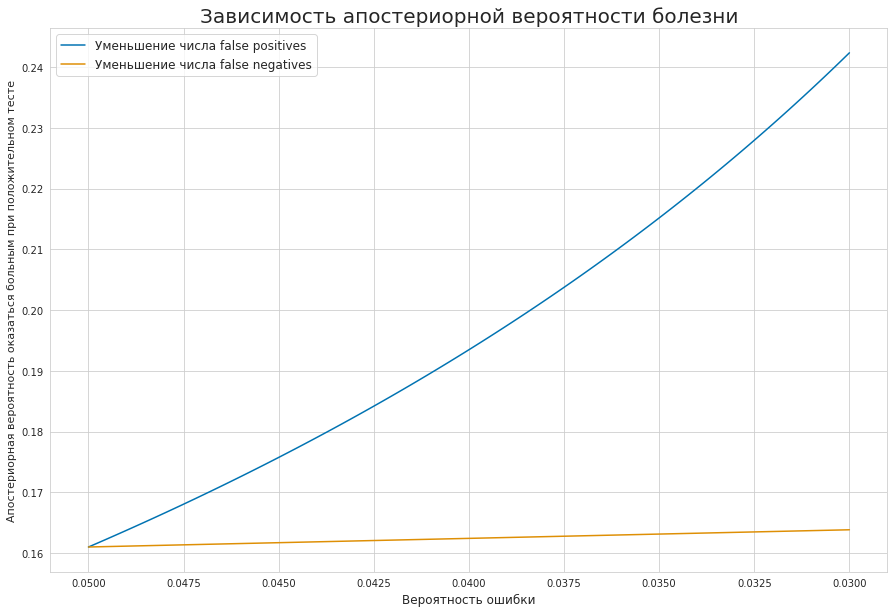

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(x, disease(p_fp=x), label='Уменьшение числа false positives')
ax.plot(x, disease(p_fn=x), label='Уменьшение числа false negatives')
ax.legend(loc="upper left", fontsize=12.0)
ax.invert_xaxis()
ax.set_title("Зависимость апостериорной вероятности болезни", fontsize=20.0)
ax.set_xlabel("Вероятность ошибки", fontsize=12.0)
ax.set_ylabel("Апостериорная вероятность оказаться больным при положительном тесте", fontsize=11.0)
plt.show()

Ответ:

Врачам следует сосредоточиться на снижении числа false positives (когда тест выдаёт положительный результат у здорового человека), так как апостериорная вероятность оказаться больным при положительном тесте растет быстрее, чем при снижении числа false negatives (когда тест выдаёт отрицательный результат у больного).

# Часть II: О линейной регрессии

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). Иначе говоря, мы будем “играть” за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.

In [5]:
response = requests.get('https://covid.ourworldindata.org/data/owid-covid-data.csv')
file_object = io.StringIO(response.content.decode('utf-8'))
covid_data = pd.read_csv(file_object)

In [6]:
in_russia = covid_data[(covid_data['location'] == 'Russia') & (covid_data['date'] >= '2020-03-03')]

In [7]:
in_russia.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
52775,RUS,Europe,Russia,2020-03-03,3.0,0.0,0.143,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52776,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52777,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52778,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52779,RUS,Europe,Russia,2020-03-07,13.0,0.0,1.571,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824


In [8]:
in_russia['new_cases'] = in_russia['new_cases'].apply(lambda x: x if x > 0. else 1.)

<ipython-input-8-dad904e3a130>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_russia['new_cases'] = in_russia['new_cases'].apply(lambda x: x if x > 0. else 1.)


In [9]:
train = in_russia.iloc[:50, :]
test = in_russia.iloc[50:, :]

In [10]:
train.shape

(50, 59)

In [11]:
test.shape

(310, 59)

2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

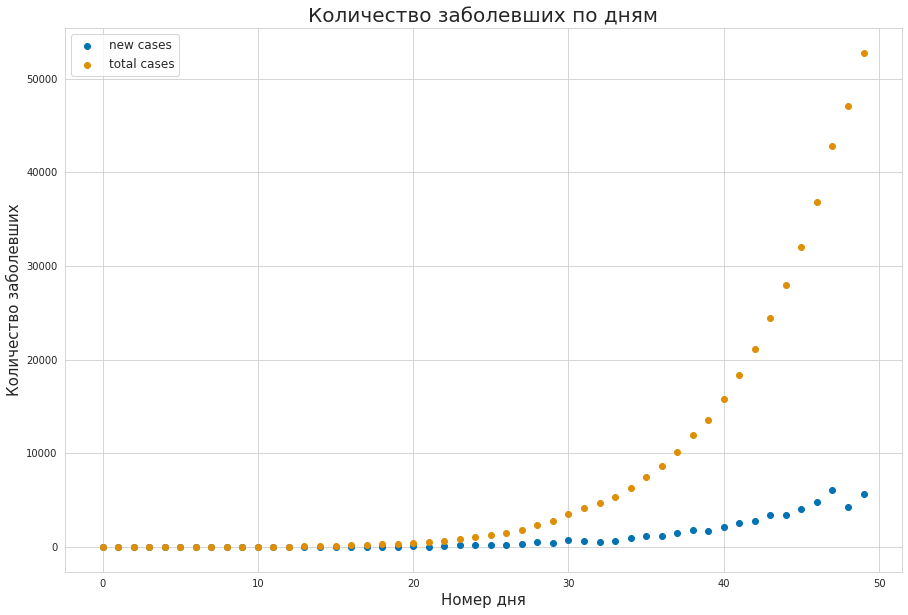

In [12]:
x = np.arange(0, 50)

plt.figure(figsize=(15, 10))
plt.scatter(x, train['new_cases'], label='new cases')
plt.scatter(x, train['total_cases'], label='total cases')
plt.legend(loc="upper left", fontsize=12.0)
plt.title('Количество заболевших по дням', fontsize=20.0)
plt.xlabel('Номер дня', fontsize=15.0)
plt.ylabel('Количество заболевших', fontsize=15.0)
plt.show()

    a. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [13]:
X = np.arange(0, 50).reshape(-1, 1)
y = np.log(train['total_cases'])

In [14]:
exp_model = LinearRegression()

In [15]:
exp_model.fit(X, y)

LinearRegression()

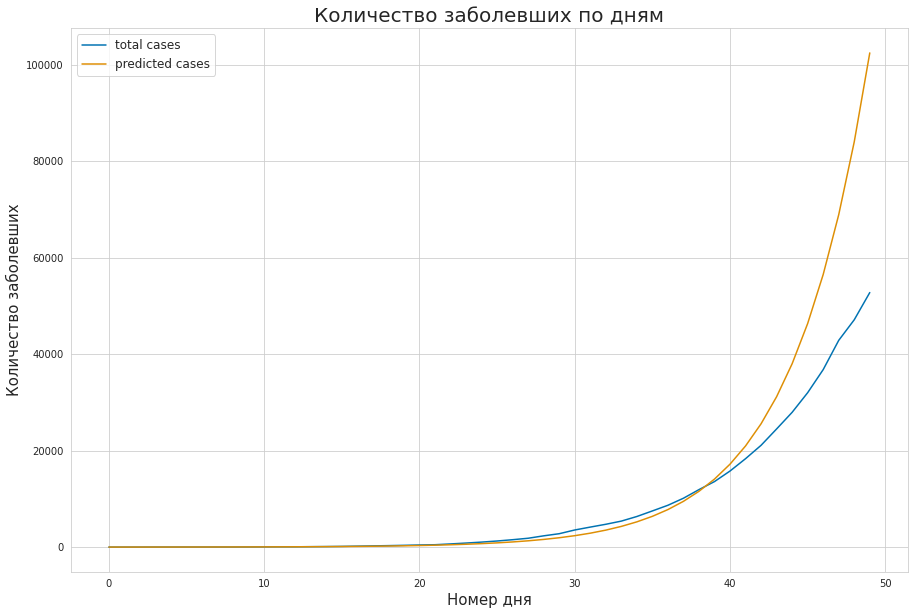

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(X, train['total_cases'], label='total cases')
plt.plot(X, np.exp(exp_model.predict(X)), label='predicted cases')
plt.legend(loc="upper left", fontsize=12.0)
plt.title('Количество заболевших по дням', fontsize=20.0)
plt.xlabel('Номер дня', fontsize=15.0)
plt.ylabel('Количество заболевших', fontsize=15.0)
plt.show()

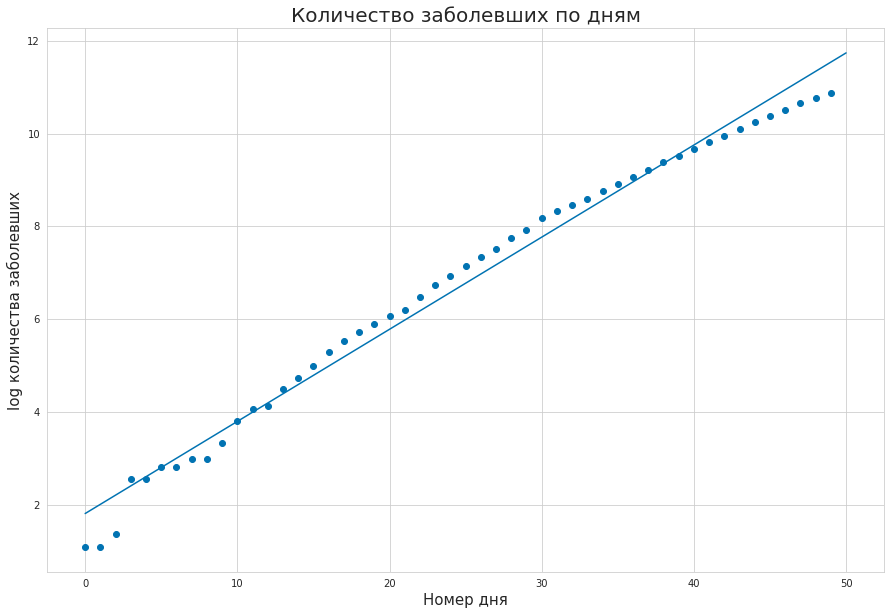

In [19]:
xx = np.linspace(0, 50, 100)

plt.figure(figsize=(15, 10))
plt.plot(xx, exp_model.predict(xx.reshape(-1, 1)))
plt.scatter(np.arange(0, 50).reshape(-1, 1), y)
plt.title('Количество заболевших по дням', fontsize=20.0)
plt.xlabel('Номер дня', fontsize=15.0)
plt.ylabel('log количества заболевших', fontsize=15.0)
plt.show()

In [20]:
#расчитаем ошибку предсказаний
error = exp_model.predict(np.arange(0, 50).reshape(-1,1)) - y
error.std(), error.mean()

(0.35258587251021284, 5.284661597215745e-16)

    b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [21]:
xs = np.linspace(0, 50, 250)
X = np.linspace(-3, 3, 250)
Y = np.linspace(-3, 3, 250)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [22]:
def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    #plt.scatter(exp_model.intercept_, exp_model.coef_, marker='*', s=120)

(250, 250)


<ipython-input-22-fbe429483137>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


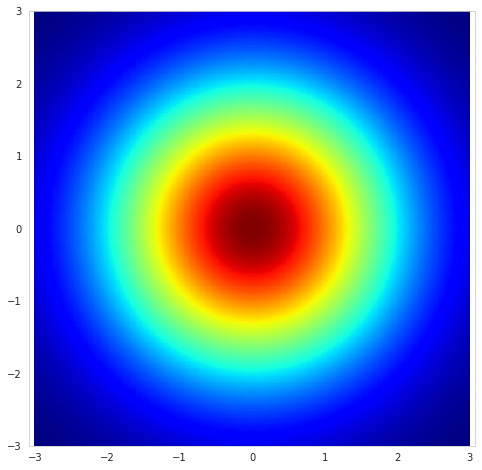

In [23]:
px, py = 0, y.values[0]
cur_mu, cur_sigma = np.array([0, 0]), 2 * np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
myplot_heatmap(Z)

In [24]:
def get_likelihood(px, py, sigma=.5):
    return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))

In [25]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [26]:
def sample_exponents(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем экспоненты
    samples = []
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        samples.append(w)
        plt.plot(xs, np.exp(w[0]) * np.exp(w[1])**xs, 'k-', lw=.4)
    plt.ylim((0, 60000))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    return np.mean(samples, axis=0)

<ipython-input-22-fbe429483137>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


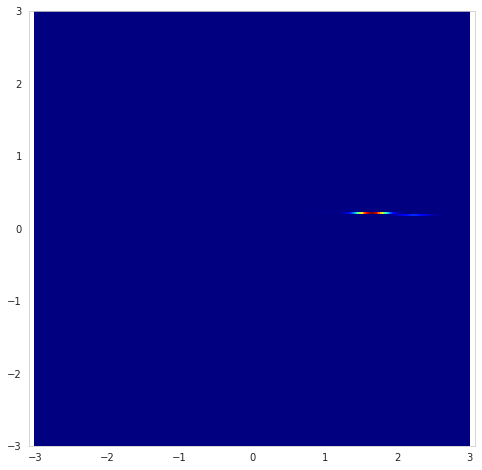

In [27]:
for k in range(50):
    px, py = k, y.values[k]
    cur_likelihood = get_likelihood(px, py)
    Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
    
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, sigma_noise=error.std() * 3)
    Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
myplot_heatmap(Z)

array([1.77649941, 0.20101571])

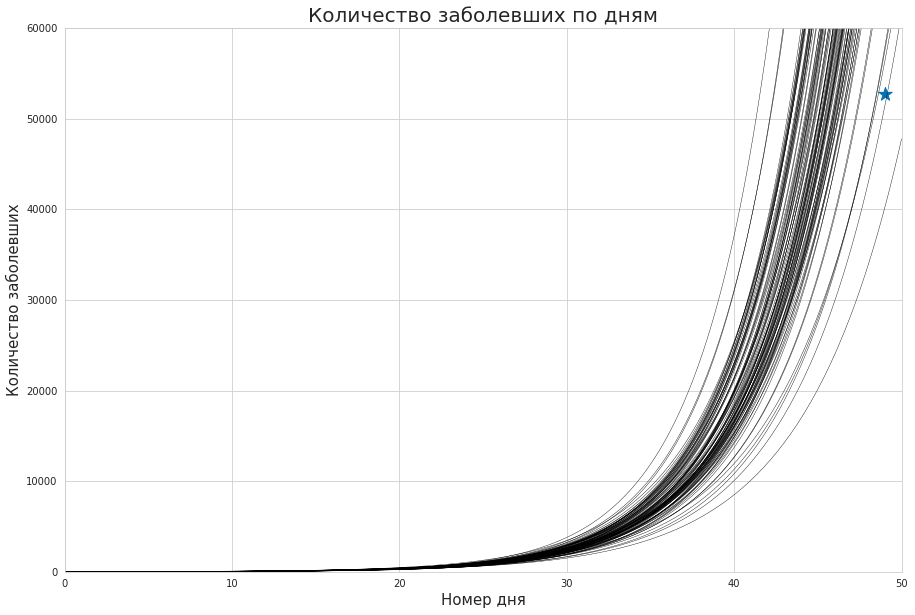

In [28]:
# Посэмплируем и порисуем экспоненты
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_title('Количество заболевших по дням', fontsize=20.0)
ax.set_xlabel('Номер дня', fontsize=15.0)
ax.set_ylabel('Количество заболевших', fontsize=15.0)
sample_exponents(cur_mu, cur_sigma, 100, points=[[px], [np.exp(py)]])

In [29]:
# Посэмплируем экспоненты и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0]) * np.exp(w[1])**xs
    return res

In [30]:
# Нарисуем результат
def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((0, 60000))
    ax.plot(xs, np.exp(exp_model.predict(xs.reshape(-1, 1))), label="Обученная модель")
    ax.plot(xs, np.exp(mu[0]) * np.exp(mu[1])**xs, color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(exp_model.predict(xs.reshape(-1, 1))) - .25, np.exp(exp_model.predict(xs.reshape(-1, 1))) + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.set_title('Количество заболевших по дням', fontsize=20.0)
    ax.set_xlabel('Номер дня', fontsize=15.0)
    ax.set_ylabel('Количество заболевших', fontsize=15.0)
    ax.legend(fontsize=legend_fontsize)

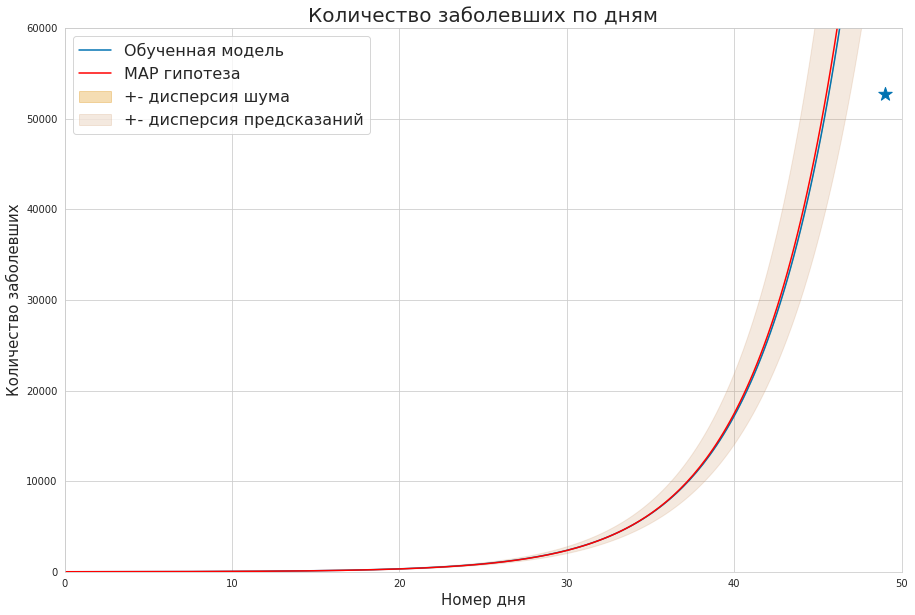

In [31]:
x = sample_statistics(cur_mu, cur_sigma, xs, n=1000)
plot_predictions(xs, cur_mu, x, [[px], [np.exp(py)]])

    c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

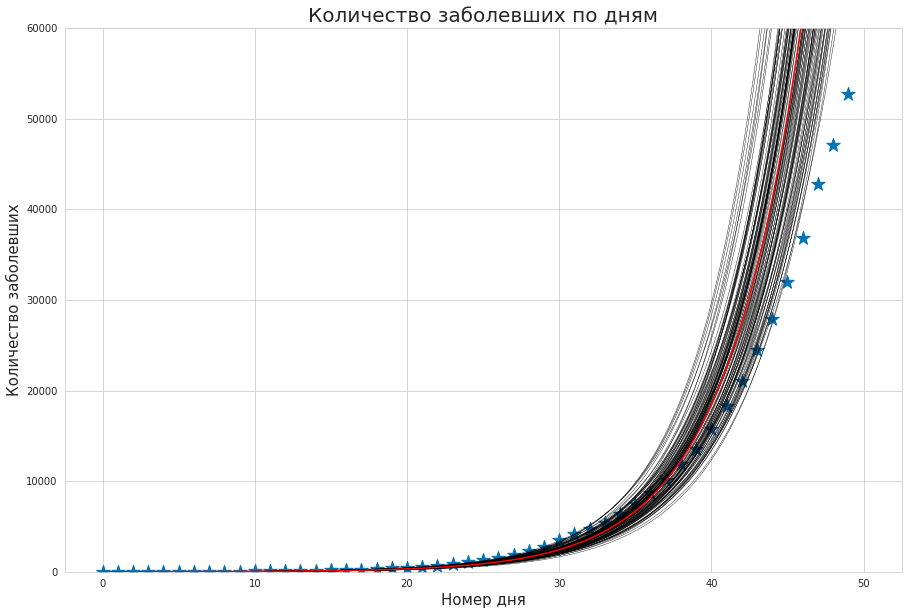

In [32]:
plt.figure(figsize=(15, 10))
samples = sample_exponents(cur_mu, cur_sigma, 100, [range(50), train['total_cases'].values])
plt.plot(xs, np.exp(samples[0]) * np.exp(samples[1])**xs, color='red')
plt.title('Количество заболевших по дням', fontsize=20.0)
plt.xlabel('Номер дня', fontsize=15.0)
plt.ylabel('Количество заболевших', fontsize=15.0)
plt.show()

In [33]:
may_1_index = (test[test['date'] == '2020-05-01'].index - train.head(1).index)[0]
june_1_index = (test[test['date'] == '2020-06-01'].index - train.head(1).index)[0]
september_1_index = (test[test['date'] == '2020-09-01'].index - train.head(1).index)[0]

may_1_cases = test[test['date'] == '2020-05-01']['total_cases']
june_1_cases = test[test['date'] == '2020-06-01']['total_cases']
september_1_cases = test[test['date'] == '2020-09-01']['total_cases']

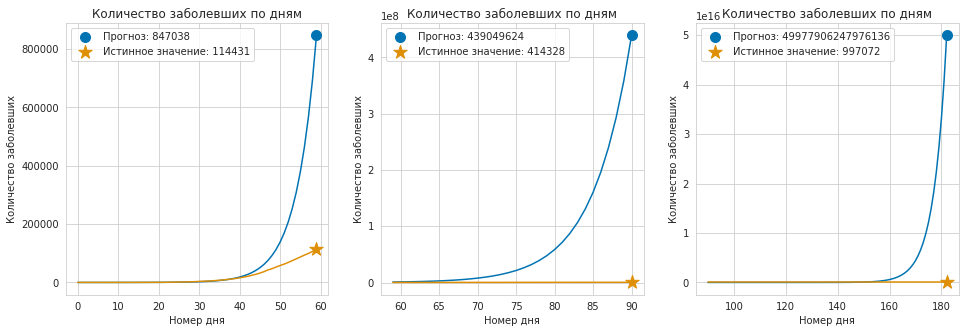

In [34]:
xxx = range(may_1_index + 1)
dates = np.array([0, may_1_index, june_1_index, september_1_index])
real_cases = np.array([may_1_cases, june_1_cases, september_1_cases])

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
for date, case, ax in zip(range(1, len(dates)), real_cases, axs):
    before_date = range(dates[date - 1], dates[date] + 1)
    ax.plot(before_date, np.exp(samples[0]) * np.exp(samples[1])**before_date)
    ax.plot(before_date, in_russia.iloc[dates[date - 1]:dates[date] + 1, 4])
    predicted_case = np.exp(samples[0]) * np.exp(samples[1])**dates[date]
    ax.scatter(dates[date], predicted_case, marker='o', s=100, label=f'Прогноз: {predicted_case:.0f}')
    ax.scatter(dates[date], case, marker='*', s=200, label=f'Истинное значение: {case[0]:.0f}')
    ax.set_title('Количество заболевших по дням', fontsize=12.0)
    ax.set_xlabel('Номер дня', fontsize=10.0)
    ax.set_ylabel('Количество заболевших', fontsize=10.0)
    ax.legend()

Средние веса сэмлированной экспоненты, выдают очень пессиместичные предсказания.

3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана.

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

    a. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

In [35]:
X = np.transpose(np.array([np.arange(0, 50), np.arange(0, 50)**2]))
y = np.log(train['new_cases'])
sigmoid_model = LinearRegression()
sigmoid_model.fit(X, y)

LinearRegression()

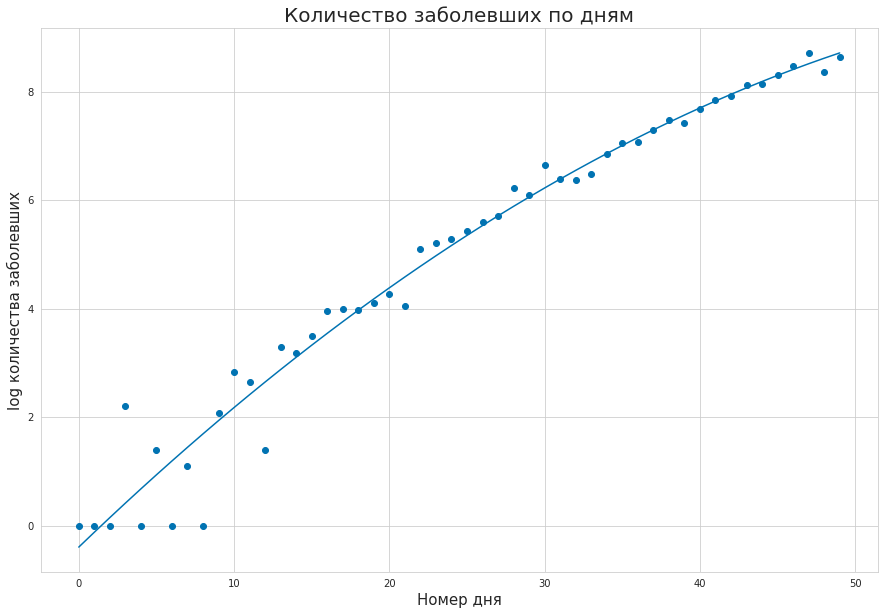

In [36]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, 50), sigmoid_model.predict(X))
plt.scatter(np.arange(0, 50), np.log(train['new_cases']))
plt.title('Количество заболевших по дням', fontsize=20.0)
plt.xlabel('Номер дня', fontsize=15.0)
plt.ylabel('log количества заболевших', fontsize=15.0)
plt.show()

In [37]:
def sigmoid_preds(model, X):
    return np.cumsum(np.exp(model.predict(X)))

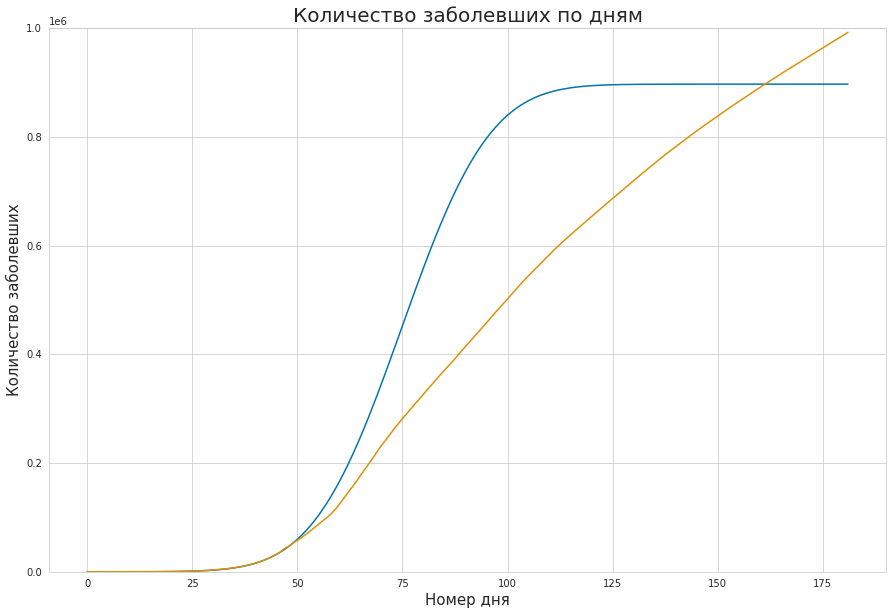

In [38]:
X_tot = np.transpose(np.array([np.arange(0, september_1_index), np.arange(0, september_1_index)**2]))

plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, september_1_index), sigmoid_preds(sigmoid_model, X_tot))
plt.plot(np.arange(0, september_1_index), in_russia['total_cases'].iloc[:september_1_index])
plt.ylim([0, 1000000])
plt.title('Количество заболевших по дням', fontsize=20.0)
plt.xlabel('Номер дня', fontsize=15.0)
plt.ylabel('Количество заболевших', fontsize=15.0)
plt.show()

In [39]:
#посчитаем ошибку предсказания
error = sigmoid_model.predict(X) - y
error.std(), error.mean()

(0.4941358580329243, -6.039613253960852e-16)

    b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.


In [40]:
W0 = np.linspace(-3, 3, 50)
W1 = np.linspace(-3, 3, 50)
W2 = np.linspace(-3, 3, 50)
W0, W1, W2 = np.meshgrid(W0, W1, W2)

pos = np.hstack(
    (
        np.moveaxis(W0, 0, -1).reshape(np.prod(W0.shape), 1), 
        np.moveaxis(W2, 0, -1).reshape(np.prod(W2.shape), 1), 
        np.moveaxis(W1, 0, -1).reshape(np.prod(W1.shape), 1)
    )
)

In [41]:
px, py = 0, y.values[0]
cur_mu, cur_sigma = np.array([0, 0, 0]), 2 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

(125000,)


In [42]:
def get_likelihood_2(px, py, sigma=.5):
    return lambda x : np.exp(-(x[0] + x[1] * px + x[2] * px**2 - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))

In [43]:
def bayesian_update_2(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [44]:
def sample_sigmoids(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем сигмоиды
    samples = []
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        samples.append(w)
        plt.plot(xs, np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2)), 'k-', lw=.4)
    plt.ylim((0, 100000))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    return np.percentile(samples, 50, axis=0), np.percentile(samples, 90, axis=0), np.percentile(samples, 10, axis=0)

In [45]:
px, py = 0, y.values[0]
cur_mu, cur_sigma = np.array([0, 0, 0]), 2 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

for day in range(50):
    px, py = day, y.values[day]
    cur_likelihood = get_likelihood_2(px, py)
    Z = np.array([cur_likelihood(i) for i in pos])
    
    cur_mu, cur_sigma = bayesian_update_2(cur_mu, cur_sigma, px, py, sigma_noise=error.std()/2)
    Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

    c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [46]:
xs = np.linspace(0, 200, 200)

(array([-0.38405346,  0.27743836, -0.00187558]),
 array([-0.26967025,  0.28767553, -0.00151191]),
 array([-0.5527379 ,  0.26012806, -0.00209591]))

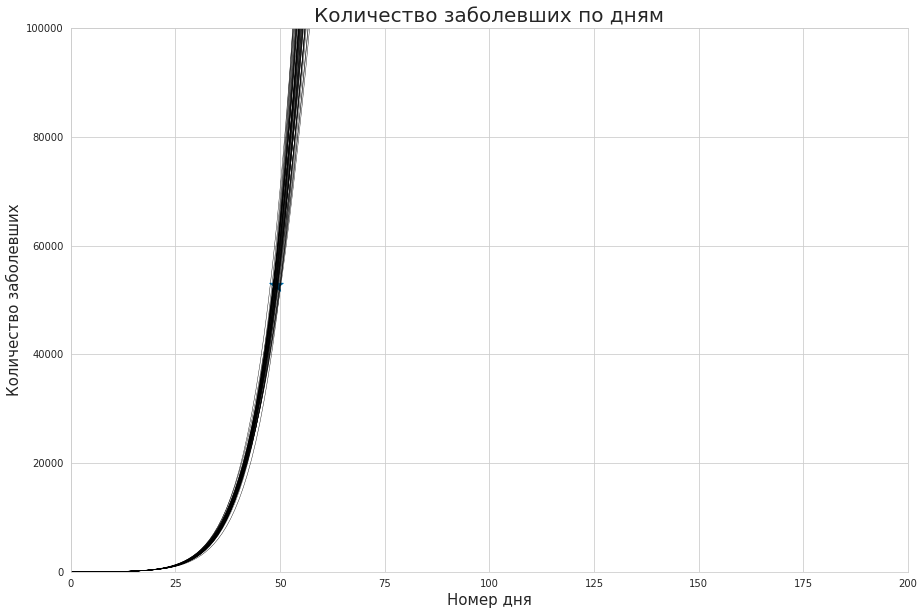

In [47]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_title('Количество заболевших по дням', fontsize=20.0)
ax.set_xlabel('Номер дня', fontsize=15.0)
ax.set_ylabel('Количество заболевших', fontsize=15.0)
sample_sigmoids(cur_mu, cur_sigma, 50, points=[[px], [train['total_cases'].values[day]]])

In [48]:
# Посэмплируем сигмоиды и выдадим статистики по предсказаниям
def sample_statistics_2(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))
    return res

In [49]:
# Нарисуем результат
def plot_predictions_2(xs, mu, x, points):
    xs_tot = np.transpose(np.array([xs, xs**2]))
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((0, 1_000_000))
    ax.plot(xs, sigmoid_preds(sigmoid_model, xs_tot), label="Обученная модель")
    ax.plot(xs, np.cumsum(np.exp(mu[0] + mu[1]*xs + mu[2]*xs**2)), color="red", label="MAP гипотеза")
    ax.fill_between(xs, sigmoid_preds(sigmoid_model, xs_tot) - .25, sigmoid_preds(sigmoid_model, xs_tot) + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.set_title('Количество заболевших по дням', fontsize=20.0)
    ax.set_xlabel('Номер дня', fontsize=15.0)
    ax.set_ylabel('Количество заболевших', fontsize=15.0)
    ax.legend(fontsize=legend_fontsize)

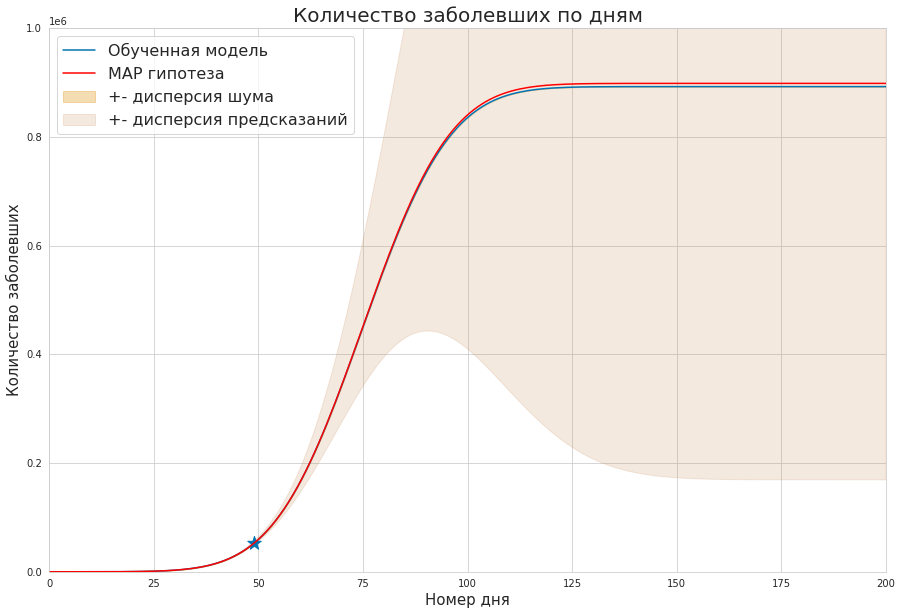

In [50]:
x = sample_statistics_2(cur_mu, cur_sigma, xs, n=1000)
plot_predictions_2(xs, cur_mu, x, [[px], [train['total_cases'].values[day]]])

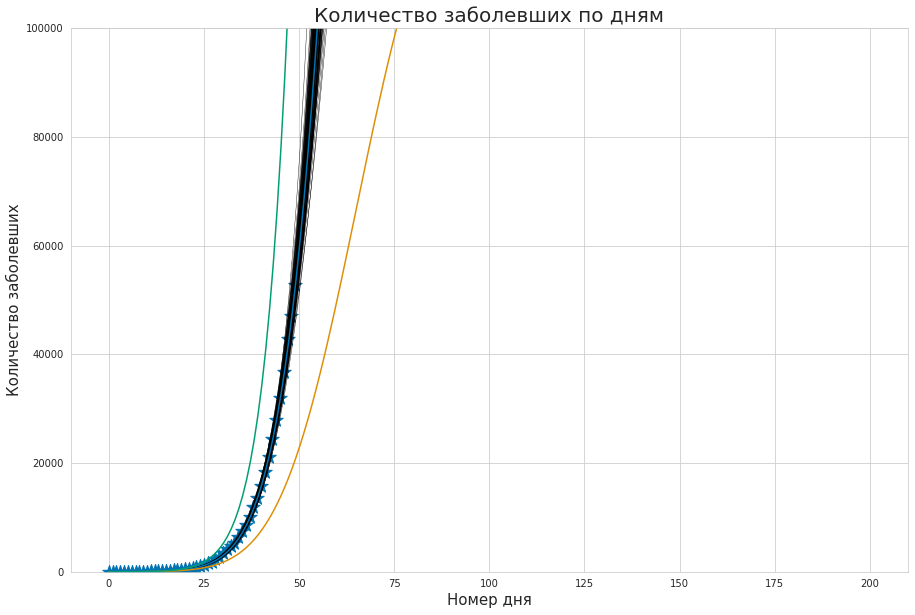

In [51]:
plt.figure(figsize=(15, 10))
p50, p90, p10 = sample_sigmoids(cur_mu, cur_sigma, 100, [range(50), train['total_cases'].values])
plt.plot(xs, np.cumsum(np.exp(p50[0] + p50[1]*xs + p50[2]*xs**2)))
plt.plot(xs, np.cumsum(np.exp(p10[0] + p10[1]*xs + p10[2]*xs**2)))
plt.plot(xs, np.cumsum(np.exp(p90[0] + p90[1]*xs + p90[2]*xs**2)))
plt.title('Количество заболевших по дням', fontsize=20.0)
plt.xlabel('Номер дня', fontsize=15.0)
plt.ylabel('Количество заболевших', fontsize=15.0)
plt.show()

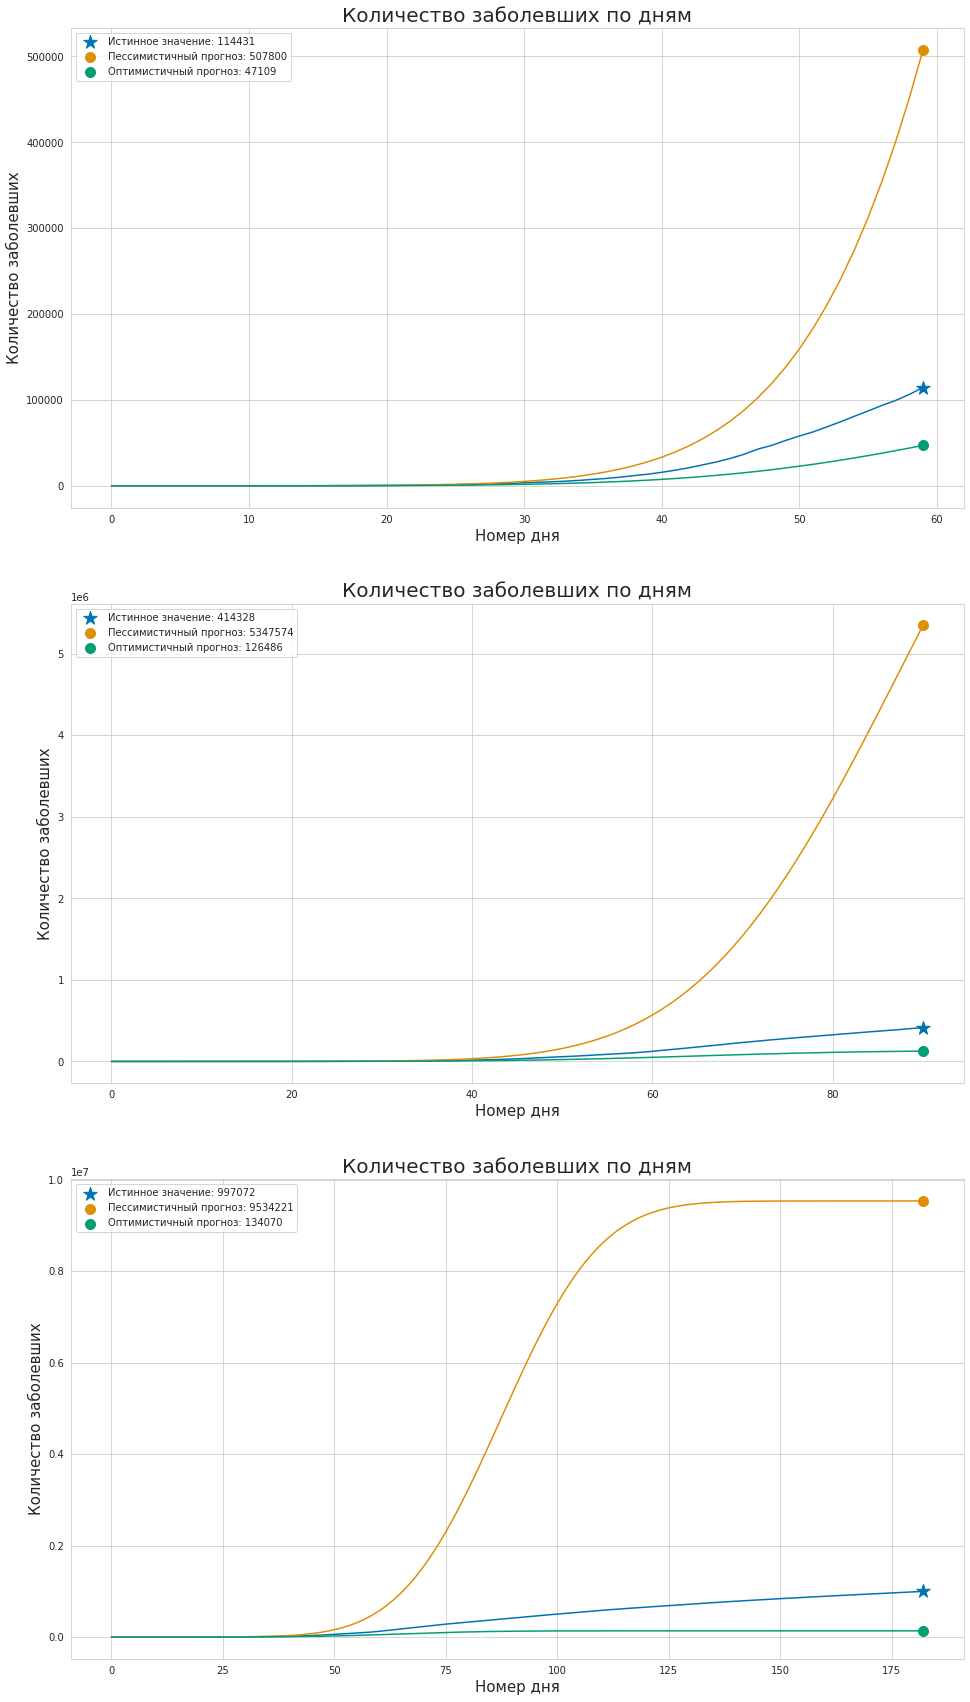

In [52]:
xxx = range(may_1_index + 1)
dates = np.array([0, may_1_index, june_1_index, september_1_index])
real_cases = np.array([may_1_cases, june_1_cases, september_1_cases])

fig, axs = plt.subplots(3, 1, figsize=(16, 30))
for date, case, ax in zip(range(1, len(dates)), real_cases, axs):
    before_date = np.array(range(0, dates[date] + 1))
    ax.plot(before_date, in_russia.iloc[:dates[date] + 1, 4])
    ax.plot(before_date, np.cumsum(np.exp(p90[0] + p90[1] * before_date + p90[2] * before_date**2)))
    ax.plot(before_date, np.cumsum(np.exp(p10[0] + p10[1] * before_date + p10[2] * before_date**2)))
    
    
    predicted_p50 = np.cumsum(np.exp(p50[0] + p50[1] * before_date + p50[2] * before_date**2))[-1]
    predicted_p10 = np.cumsum(np.exp(p10[0] + p10[1] * before_date + p10[2] * before_date**2))[-1]
    predicted_p90 = np.cumsum(np.exp(p90[0] + p90[1] * before_date + p90[2] * before_date**2))[-1]
    
    ax.scatter(dates[date], case, marker='*', s=200, label=f'Истинное значение: {case[0]:.0f}')
    ax.scatter(dates[date], predicted_p90, marker='o', s=100, label=f'Пессимистичный прогноз: {predicted_p90:.0f}')
    ax.scatter(dates[date], predicted_p10, marker='o', s=100, label=f'Оптимистичный прогноз: {predicted_p10:.0f}')
    ax.set_title('Количество заболевших по дням', fontsize=20.0)
    ax.set_xlabel('Номер дня', fontsize=15.0)
    ax.set_ylabel('Количество заболевших', fontsize=15.0)
    ax.legend()

Ответ: прогноз выглядит более правдоподобным, чем в случае с экспоненциальной моделью.